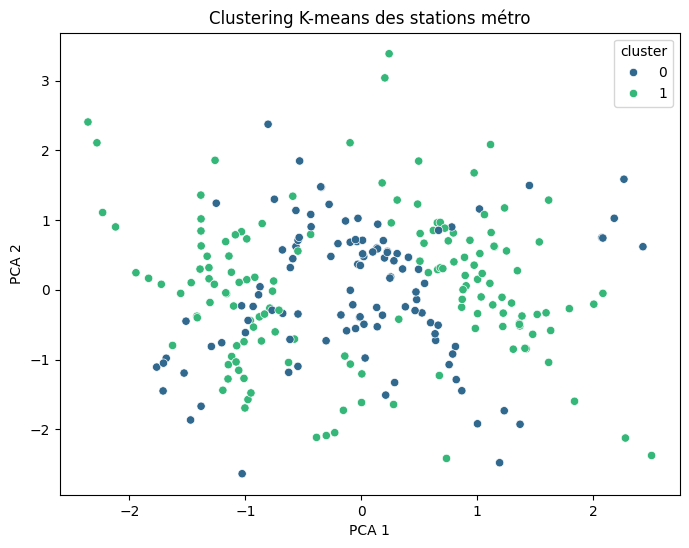

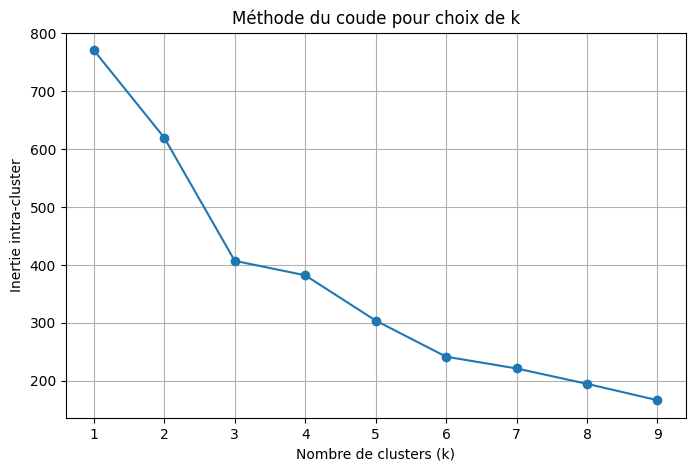

Statistiques moyennes par cluster :


,pollution_num,stop_lon,stop_lat
cluster,,,
0,2.018,2.318,48.856
1,1.490,2.363,48.867


Répartition des clusters :


cluster
0    110
1    147
Name: count, dtype: int64

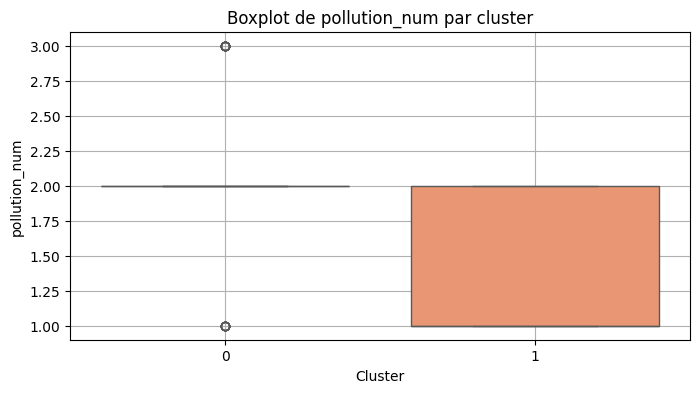

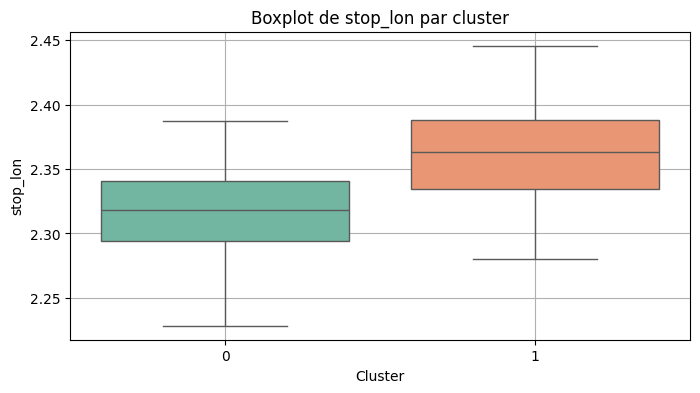

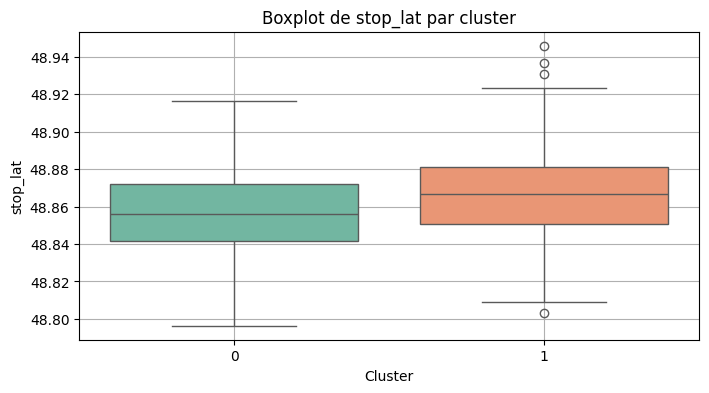

In [5]:
### Notebook: Analyse k-means pollution ###

### AVEC K = 2 ###

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# chargement des données et localisation du fichier train.csv automatiquement
base_dir = os.path.dirname(os.getcwd())  # monte d’un niveau
csv_path = os.path.join(base_dir, "Data", "processed", "train.csv")

# chargement du fichier CSV
df = pd.read_csv(csv_path)
df = df[df['niveau_pollution'] != 'pas de données']

#transformation des pollutions en valeur numerique pour pouvoir fair la methode des k-means
pollution_mapping = {
    'pollution faible': 1,
    'pollution moyenne': 2,
    'pollution élevée': 3
}
df['pollution_num'] = df['niveau_pollution'].map(pollution_mapping)

#les colonnes numériques pour construire les clusters
features = ['pollution_num', 'stop_lon', 'stop_lat']
df_clean = df[features].dropna()

# standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

#déterminer le bon nombre de clusters
inertias = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# K-means
kmeans = KMeans(n_clusters=2, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_clean['PCA1'] = X_pca[:, 0]
df_clean['PCA2'] = X_pca[:, 1]

# Visualisation en creant des graphques
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title('Clustering K-means des stations métro')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.title("Méthode du coude pour choix de k")
plt.grid(True)
plt.show()

# moyenne des variables pour chaque cluster
cluster_stats = df_clean.groupby('cluster')[['pollution_num', 'stop_lon', 'stop_lat']].mean().round(3)
print("Statistiques moyennes par cluster :")
display(cluster_stats)

# répartition des stations par cluster (on test si les classes sont equilibrés )
cluster_counts = df_clean['cluster'].value_counts().sort_index()
print("Répartition des clusters :")
display(cluster_counts)

# boxplot pour chaque variable par cluster
for var in ['pollution_num', 'stop_lon', 'stop_lat']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_clean, x='cluster', y=var, hue='cluster', palette='Set2', legend=False)
    plt.title(f"Boxplot de {var} par cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(True)
    plt.show()



In [6]:
### interpretation du graphique

#Le graphique ci-dessus represente un résultat de l’algorithme K-means appliqué aux stations de métro dans notre fichier csv. Chaque point correspond à une station de metro, projetee dans un plan à deux dimensions grace à une réduction de dimension analyse en composantes principale. Cette réduction nous permet de visualiser les groupes sans perdre trop d'information sur trois dimensions réels : pollution, longitude, latitude

#Chaque couleur indique le cluster auquel appartient la station :
#- Les stations d’un même cluster partagent un profil similaire en termes de localisation géographique du coup (longitude,latitude) et de niveau de pollution.
#- Le modèle va automatiquement regrouper ces stations en deux categories visuellement separees.

#le cluster numero 0 regroupe les stations les plus propres avec une pollution_num = 1.00.

#Clusters numero 1 regroupent les stations plus polluées avec une pollution_num = 2.05.

#Il est possible de changer le nombre de cluster en allant dans la ligne "kmeans = KMeans(n_clusters=2, random_state=42)" en augmentant ou diminuant le numero n_clusters. Il est possible de prendre le graphique de la méthode du coude pour voir le résultat que ça donne lorsqu'on augmente le k de clusters. 

#exemple de quand on augmente les clusters : 

## pour k=4 par exemple : on a des groupes des groupes avec des pollutions plutot proches (c'est pour ceci qu'oon a decidé que k=2 est l'option la plus pertienente) avec des latitudes et des longitudes variantes : cluster 0 c'est pollution = 2.042, long = 2.312, lat = 48.838 , cluster 1 pollution = 2.000, long = 2.313, lat = 48.884 on voit entre ces 2 clusters que le niveau de pollution est different, les clusters ont des metros avec un niveau de pollution entre moyen et elevé mais les metros du cluster 0 emettent plus de pollutions.

### Vous trouverez ci-dessous les graphiques et les tableaux de chaque methode de k-mean avec un k different (On a choisi de montrer k=4 et k =9).

## Vu que nous avions changé chaque niveau de pollution en 1,2 ou 3. la moyenne de pollution ne varie pass enormément car les stations sont majoritairement faible ou moyenne (c pour cela que les moyennes de pollution sont presque entier). 

## Vous trouverez egalement un boxplot pour chaque classe et la repartition des cluster avec le nombre de stations dans chaque cluster. 


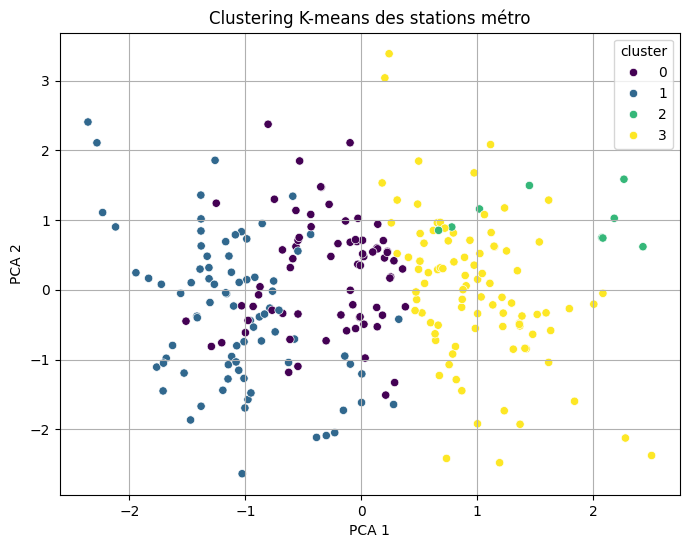

Statistiques moyennes par cluster :


,pollution_num,stop_lon,stop_lat
cluster,,,
0,2.014,2.305,48.862
1,1.000,2.335,48.863
2,3.000,2.346,48.870
3,1.979,2.379,48.861


Répartition des clusters :


cluster
0    72
1    81
2     9
3    95
Name: count, dtype: int64

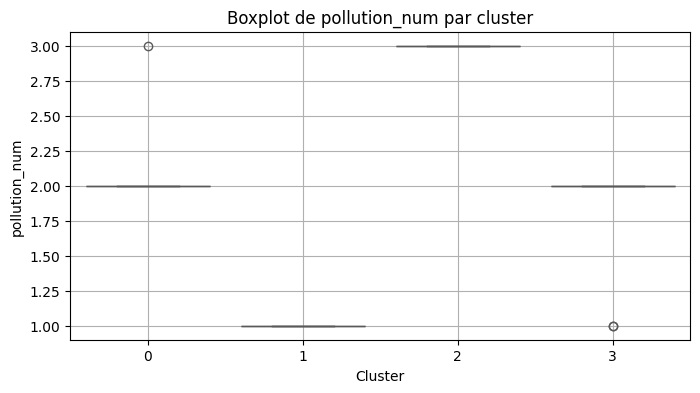

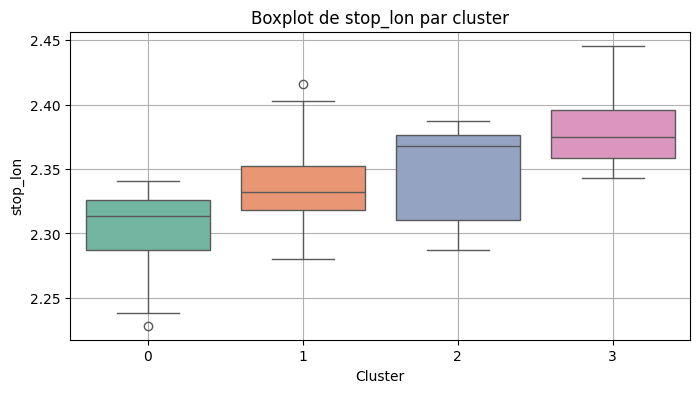

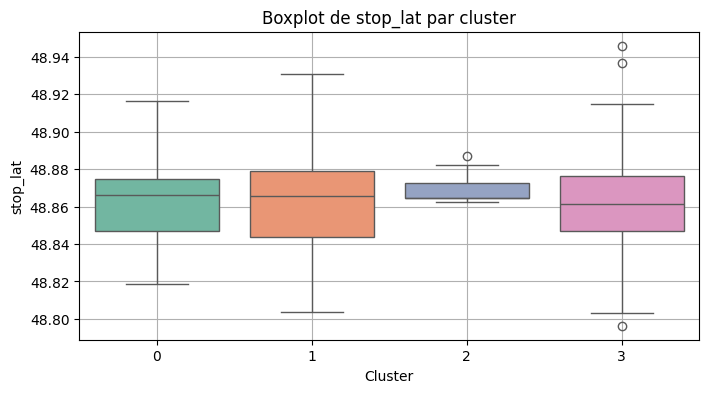

In [7]:
### Notebook: Analyse k-means pollution ###


### AVEC K = 4 ###


import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# chargement des données et localisation du fichier train.csv automatiquement
base_dir = os.path.dirname(os.getcwd())  # monte d’un niveau
csv_path = os.path.join(base_dir, "Data", "processed", "train.csv")

# chargement du fichier CSV
df = pd.read_csv(csv_path)
df = df[df['niveau_pollution'] != 'pas de données']

#transformation des pollutions en valeur numerique pour pouvoir fair la methode des k-means
pollution_mapping = {
    'pollution faible': 1,
    'pollution moyenne': 2,
    'pollution élevée': 3
}
df['pollution_num'] = df['niveau_pollution'].map(pollution_mapping)

#les colonnes numériques pour construire les clusters
features = ['pollution_num', 'stop_lon', 'stop_lat']
df_clean = df[features].dropna()

# standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

#déterminer le bon nombre de clusters
inertias = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# K-means
kmeans = KMeans(n_clusters=4, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_clean['PCA1'] = X_pca[:, 0]
df_clean['PCA2'] = X_pca[:, 1]

# Visualisation en creant des graphques
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title('Clustering K-means des stations métro')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# moyennes des variables pour chaque cluster
cluster_stats = df_clean.groupby('cluster')[['pollution_num', 'stop_lon', 'stop_lat']].mean().round(3)
print("Statistiques moyennes par cluster :")
display(cluster_stats)

# répartition des stations par cluster (on test si les classes sont equilibrés )
cluster_counts = df_clean['cluster'].value_counts().sort_index()
print("Répartition des clusters :")
display(cluster_counts)

# boxplot pour chaque variable par cluster
for var in ['pollution_num', 'stop_lon', 'stop_lat']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_clean, x='cluster', y=var, hue='cluster', palette='Set2', legend=False)
    plt.title(f"Boxplot de {var} par cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(True)
    plt.show()




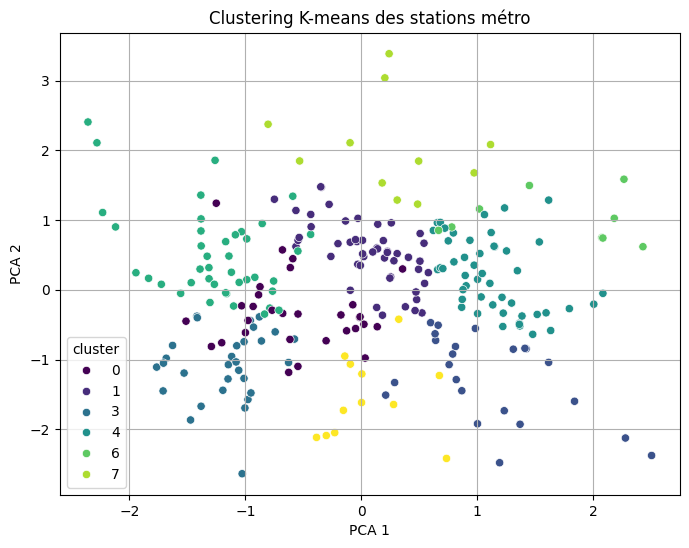

Statistiques moyennes par cluster :


,pollution_num,stop_lon,stop_lat
cluster,,,
0,2.033,2.282,48.846
1,2.000,2.330,48.871
2,2.000,2.374,48.828
3,1.000,2.323,48.844
4,2.000,2.389,48.866
5,1.000,2.332,48.885
6,3.000,2.346,48.870
7,2.000,2.352,48.911
8,1.000,2.391,48.835


Répartition des clusters :


cluster
0    30
1    52
2    23
3    30
4    49
5    41
6     9
7    11
8    12
Name: count, dtype: int64

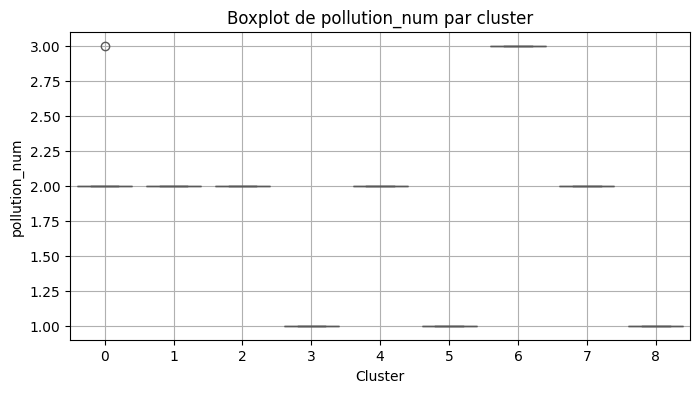

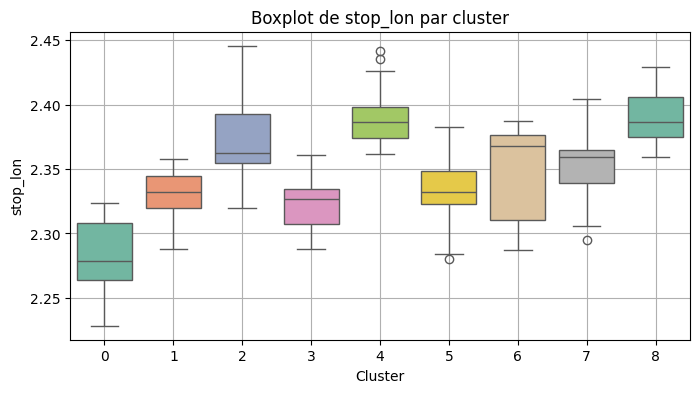

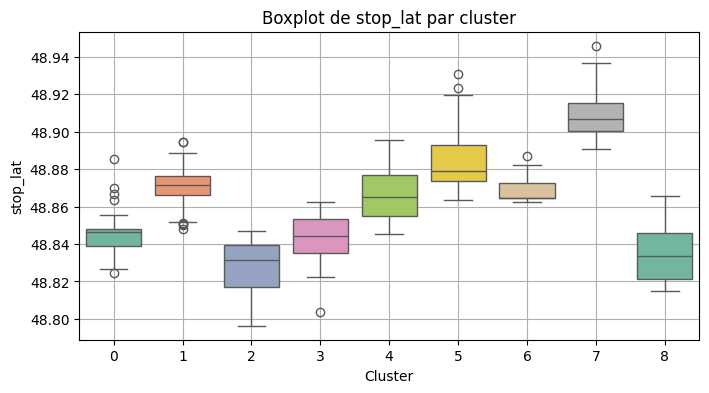

In [8]:
### Notebook: Analyse k-means pollution ###


### AVEC K = 9 ###


import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# chargement des données et localisation du fichier train.csv automatiquement
base_dir = os.path.dirname(os.getcwd())  # monte d’un niveau
csv_path = os.path.join(base_dir, "Data", "processed", "train.csv")

# chargement du fichier CSV
df = pd.read_csv(csv_path)
df = df[df['niveau_pollution'] != 'pas de données']

#transformation des pollutions en valeur numerique pour pouvoir fair la methode des k-means
pollution_mapping = {
    'pollution faible': 1,
    'pollution moyenne': 2,
    'pollution élevée': 3
}
df['pollution_num'] = df['niveau_pollution'].map(pollution_mapping)

#les colonnes numériques pour construire les clusters
features = ['pollution_num', 'stop_lon', 'stop_lat']
df_clean = df[features].dropna()

# standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

#déterminer le bon nombre de clusters
inertias = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# K-means
kmeans = KMeans(n_clusters=9, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_clean['PCA1'] = X_pca[:, 0]
df_clean['PCA2'] = X_pca[:, 1]

# Visualisation en creant des graphques
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title('Clustering K-means des stations métro')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# moyennes des variables pour chaque cluster
cluster_stats = df_clean.groupby('cluster')[['pollution_num', 'stop_lon', 'stop_lat']].mean().round(3)
print("Statistiques moyennes par cluster :")
display(cluster_stats)

# répartition des stations par cluster (on test si les classes sont equilibrés )
cluster_counts = df_clean['cluster'].value_counts().sort_index()
print("Répartition des clusters :")
display(cluster_counts)

# boxplot pour chaque variable par cluster
for var in ['pollution_num', 'stop_lon', 'stop_lat']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_clean, x='cluster', y=var, hue='cluster', palette='Set2', legend=False)
    plt.title(f"Boxplot de {var} par cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(True)
    plt.show()
